In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

C:\Users\Haresh\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [4]:
#function for calculating the uplift
def bogo_calc_uplift(df):
    avg_order_value = 25
    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()
    #calculate conversion uplift for discount and bogo
    bogo_conv_uplift = bogo_conv - base_conv
    #calculate order uplift
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])
    #calculate revenue uplift
    bogo_rev_uplift = bogo_order_uplift * avg_order_value   
    
    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))   
    
    bogo_conv_uplift = format(np.round(bogo_conv_uplift*100,2))
    bogo_order_uplift = format(np.round(bogo_order_uplift,2))
    bogo_rev_uplift = format(np.round(bogo_rev_uplift,2))
    
    return bogo_conv_uplift, bogo_order_uplift, bogo_rev_uplift

def discount_calc_uplift(df):
    avg_order_value = 25
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    disc_conv_uplift = disc_conv - base_conv
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    disc_rev_uplift = disc_order_uplift * avg_order_value
    
    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))
        
    disc_conv_uplift = format(np.round(disc_conv_uplift*100,2))
    disc_order_uplift = format(np.round(disc_order_uplift,2))
    disc_rev_uplift = format(np.round(disc_rev_uplift,2))
        
    return disc_conv_uplift, disc_order_uplift, disc_rev_uplift
     

In [5]:
df_data = pd.read_csv('data.csv')
df_data.count()

recency          64000
history          64000
used_discount    64000
used_bogo        64000
zip_code         64000
is_referral      64000
channel          64000
offer            64000
conversion       64000
dtype: int64

In [6]:
#Calculating benchmark values
disc_conv ,disc_order, disc_rev = discount_calc_uplift(df_data)
bogo_conv ,bogo_order, bogo_rev = bogo_calc_uplift(df_data)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


In [7]:
df_data['campaign_group'] = 'treatment'
df_data.loc[df_data.offer == 'No Offer', 'campaign_group'] = 'control'
df_data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0,treatment
1,6,329.08,1,1,Rural,1,Web,No Offer,0,control
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0,treatment
3,9,675.83,1,0,Rural,1,Web,Discount,0,treatment
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0,treatment


In [8]:
df_data['target_class'] = 0 #CN
df_data.loc[(df_data.campaign_group == 'control') & (df_data.conversion > 0),'target_class'] = 1 #CR
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion == 0),'target_class'] = 2 #TN
df_data.loc[(df_data.campaign_group == 'treatment') & (df_data.conversion > 0),'target_class'] = 3 #TR

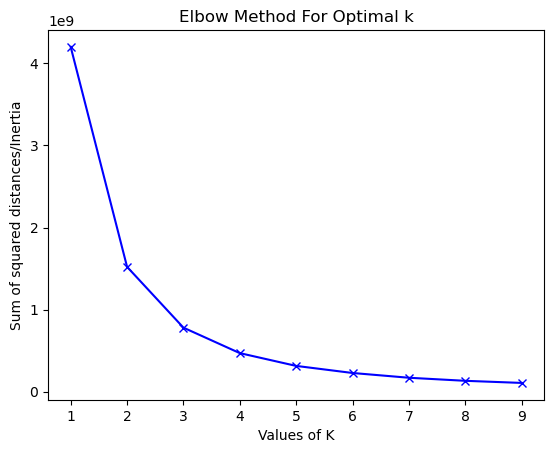

In [9]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_data['history'].values.reshape(-1,1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [10]:
#creating the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_data[['history']])
df_data['history_cluster'] = kmeans.predict(df_data[['history']])
#order the clusters
df_data = order_cluster('history_cluster', 'history',df_data,True)
#creating a new dataframe as model and dropping columns that defines the label
df_model = df_data.drop(['offer','campaign_group','conversion'],axis=1)
#convert categorical columns
df_model = pd.get_dummies(df_model)

In [11]:
df_model

,recency,history,used_discount,used_bogo,is_referral,target_class,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,2,0,0,1,0,0,1,0
1,2,45.34,1,0,0,2,0,0,0,1,0,0,1
2,6,134.83,0,1,0,3,0,0,1,0,0,1,0
3,9,46.42,0,1,0,2,0,0,0,1,0,1,0
4,10,32.84,0,1,1,2,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,2,1399.97,1,1,1,1,4,0,1,0,0,1,0
63996,1,1584.31,1,0,1,2,4,0,1,0,1,0,0
63997,1,1252.19,1,0,1,3,4,0,0,1,0,1,0
63998,2,1183.05,1,1,1,0,4,1,0,0,0,1,0


In [12]:
#create feature set and labels
X = df_model.drop(['target_class'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
#fitting the model and predicting the probabilities
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
class_probs = xgb_model.predict_proba(X_test)

C:\Users\Haresh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Haresh\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:10:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [13]:
class_probs[0]

array([0.3015881 , 0.04023404, 0.5834536 , 0.0747243 ], dtype=float32)

In [14]:
#probabilities for all customers
overall_proba = xgb_model.predict_proba(df_model.drop(['target_class'],axis=1))
#assign probabilities to 4 different columns
df_model['proba_CN'] = overall_proba[:,0] 
df_model['proba_CR'] = overall_proba[:,1] 
df_model['proba_TN'] = overall_proba[:,2] 
df_model['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_model['uplift_score'] = df_model.eval('proba_CN + proba_TR - proba_TN - proba_CR')
#assign it back to main dataframe
df_data['uplift_score'] = df_model['uplift_score']

C:\Users\Haresh\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [15]:
df_data_lift = df_data.copy()
uplift_q_75 = df_data_lift.uplift_score.quantile(0.75)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_75)].reset_index(drop=True)
print(df_data_lift.count())
#calculate the uplift
disc_conv_q75 ,disc_order_q75, disc_rev_q75 = discount_calc_uplift(df_data_lift)

recency            11657
history            11657
used_discount      11657
used_bogo          11657
zip_code           11657
is_referral        11657
channel            11657
offer              11657
conversion         11657
campaign_group     11657
target_class       11657
history_cluster    11657
uplift_score       11657
dtype: int64
Discount Conversion Uplift: 29.94%
Discount Order Uplift: 1344.31
Discount Revenue Uplift: $33607.85



In [16]:
uplift_q_80 = df_data_lift.uplift_score.quantile(0.80)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score > uplift_q_80)].reset_index(drop=True)
print(df_data_lift.count())
#calculate the uplift
disc_conv_q80 ,disc_order_q80, disc_rev_q80 = discount_calc_uplift(df_data_lift)

recency            2332
history            2332
used_discount      2332
used_bogo          2332
zip_code           2332
is_referral        2332
channel            2332
offer              2332
conversion         2332
campaign_group     2332
target_class       2332
history_cluster    2332
uplift_score       2332
dtype: int64
Discount Conversion Uplift: 61.19%
Discount Order Uplift: 451.61
Discount Revenue Uplift: $11290.24



In [17]:
df_data_lift = df_data.copy()
uplift_q_5 = df_data_lift.uplift_score.quantile(0.5)
df_data_lift = df_data_lift[(df_data_lift.offer != 'Buy One Get One') & (df_data_lift.uplift_score < uplift_q_5)].reset_index(drop=True)
print(df_data_lift.count())
#calculate the uplift
disc_conv_q50 ,disc_order_q50, disc_rev_q50 = discount_calc_uplift(df_data_lift)

recency            20195
history            20195
used_discount      20195
used_bogo          20195
zip_code           20195
is_referral        20195
channel            20195
offer              20195
conversion         20195
campaign_group     20195
target_class       20195
history_cluster    20195
uplift_score       20195
dtype: int64
Discount Conversion Uplift: -3.28%
Discount Order Uplift: -381.38
Discount Revenue Uplift: $-9534.51



In [18]:
disc_rev_q75 = float(disc_rev_q75)
disc_rev_q80 = float(disc_rev_q80)
disc_rev_q50 = float(disc_rev_q50)
disc_rev = float(disc_rev)

In [19]:
df_data_lift

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion,campaign_group,target_class,history_cluster,uplift_score
0,3,58.13,1,0,Urban,1,Web,No Offer,1,control,1,0,-0.343672
1,5,29.99,1,0,Surburban,0,Phone,Discount,0,treatment,2,0,-0.230465
2,9,29.99,0,1,Surburban,1,Phone,No Offer,0,control,0,0,-0.250541
3,6,139.87,0,1,Rural,1,Web,Discount,0,treatment,2,0,-0.260468
4,9,29.99,1,0,Surburban,1,Phone,Discount,0,treatment,2,0,-0.243103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190,1,1173.93,1,0,Urban,1,Multichannel,Discount,0,treatment,2,4,-0.559882
20191,1,1788.90,0,1,Surburban,1,Phone,Discount,0,treatment,2,4,-0.864799
20192,1,2039.13,0,1,Rural,1,Web,Discount,0,treatment,2,4,-0.910816
20193,2,1200.44,0,1,Surburban,1,Multichannel,Discount,0,treatment,2,4,-0.432031


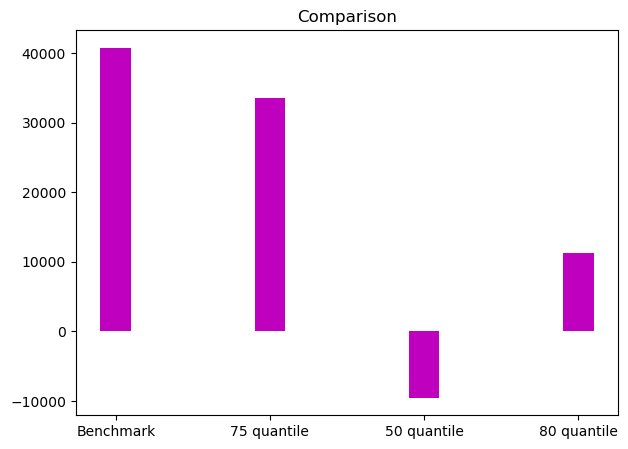

In [20]:
fig = plt.figure(figsize = (7, 5))
 
# creating the bar plot
xlabels = ["Benchmark","75 quantile","50 quantile","80 quantile"]
disc_ylabels = [disc_rev, disc_rev_q75,disc_rev_q50,disc_rev_q80]

plt.bar(xlabels,disc_ylabels,color = 'm',width = 0.2)
plt.title("Comparison")
plt.show()

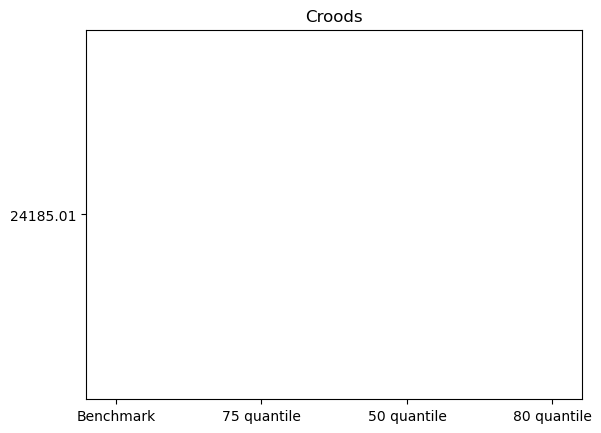

In [22]:
bogo_ylabels = [bogo_rev]
plt.bar(xlabels,bogo_ylabels,color = 'm',width = 0.1)
plt.title("Croods")
plt.show()

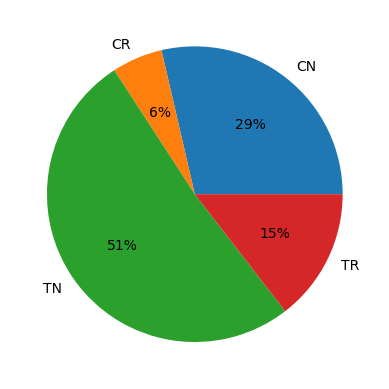

In [23]:
y = class_probs[15]
mylabels = ["CN", "CR", "TN", "TR"]
plt.pie(y, labels=mylabels, autopct='%1.0f%%')
#plt.pie(y, labels = mylabels, startangle = 90)
plt.show() 

In [24]:
class_probs[0]

array([0.3015881 , 0.04023404, 0.5834536 , 0.0747243 ], dtype=float32)